# Exploratory Data Analysis

Before we can begin training any machine learning models, the data requires some additional processing. In this section, we will be exploring our data and engineering new features to improve prediction capabilities. 

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

from sklearn import utils
from sklearn import preprocessing

#### Read in Technical Indicators

Let's read in our data again and start from scratch. In addition to TSLA, our data also includes 11 technical indicators and the S&P 500 ticker (SPY).

In [54]:
# Read data
tsla_df = pd.read_csv('TSLA_raw.csv', parse_dates=['Date']) 

# Drop unwanted columns and narrow date range
tsla_df = tsla_df[['Date','TSLA', 'Volume', 'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'MOMENTUM', 'RSI', 'EMA','MA10','MA21','MA50',
                   'STD_DEV','SPY']]
tsla_df = tsla_df[tsla_df['Date'] > datetime(2019, 9, 1)]

dates_df = tsla_df[['Date']]
dates_df = dates_df.reset_index(drop=True).reset_index().rename(columns={'index':'Day'})

tsla_df.set_index('Date', inplace=True)
tsla_df.head()

,TSLA,Volume,MACD,MACD_SIGNAL,MACD_HIST,MOMENTUM,RSI,EMA,MA10,MA21,MA50,STD_DEV,SPY
Date,,,,,,,,,,,,,
2019-09-03,45.001999,26770500,-0.727422,-0.843696,0.116274,-0.364002,49.369367,45.250614,43.944800,44.848381,46.47460,0.951591,282.708099
2019-09-04,44.136002,28805000,-0.693270,-0.813611,0.120341,-1.035999,45.946236,45.178704,43.841200,44.775619,46.46276,0.718970,285.916962
2019-09-05,45.916000,36976500,-0.516619,-0.754212,0.237594,1.750000,53.138563,45.226271,44.016200,44.764476,46.50204,0.630387,289.592499
2019-09-06,45.490002,20947000,-0.406312,-0.684632,0.278321,1.060001,51.376658,45.243286,44.122200,44.707619,46.53476,0.591917,289.816193
2019-09-09,46.358002,24013500,-0.246016,-0.596909,0.350893,4.078003,54.674370,45.315203,44.530001,44.645619,46.57056,0.767633,289.962036


Let's visualize each series individually to gain a better intuition.

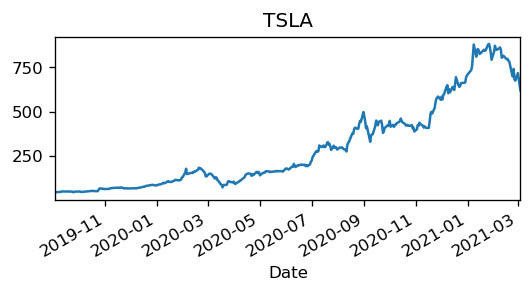

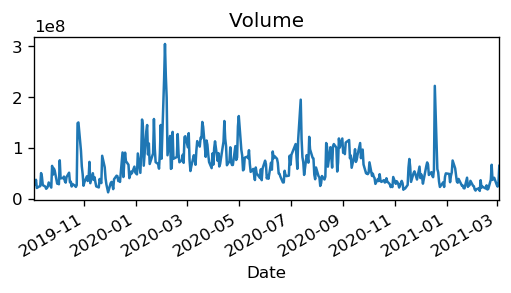

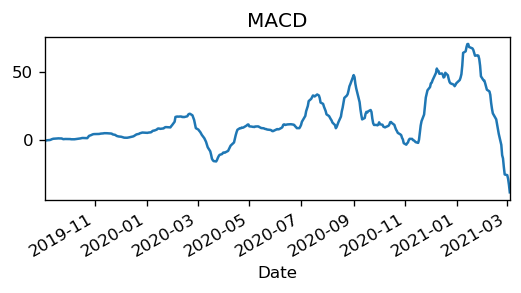

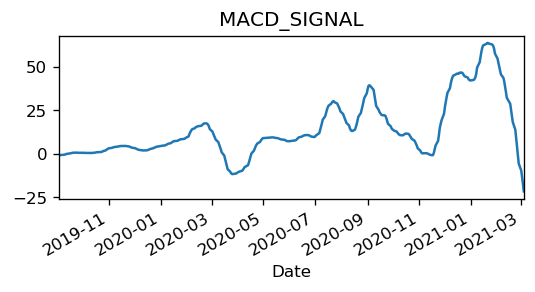

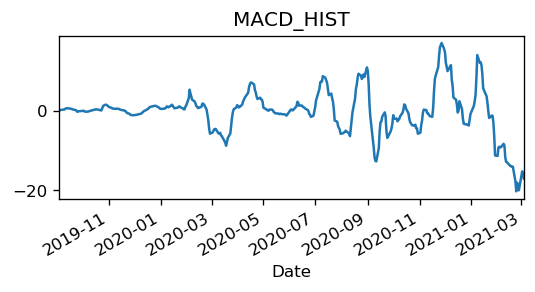

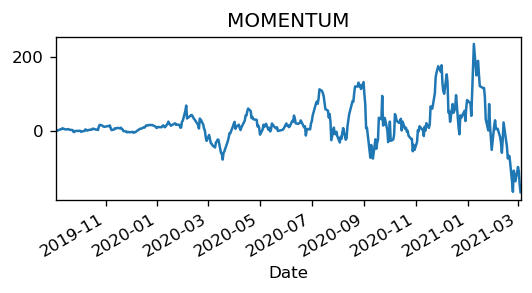

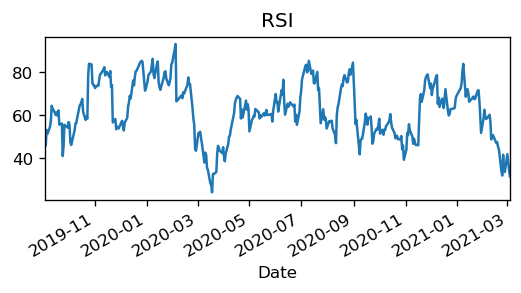

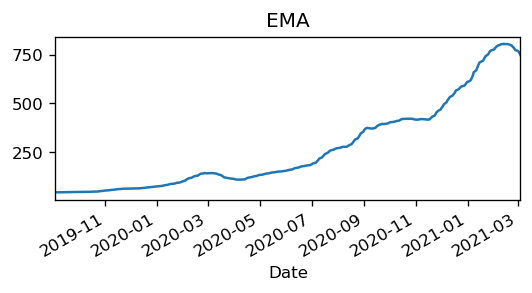

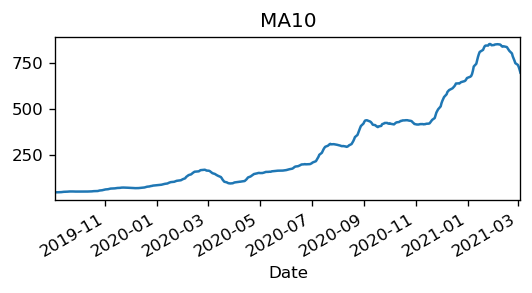

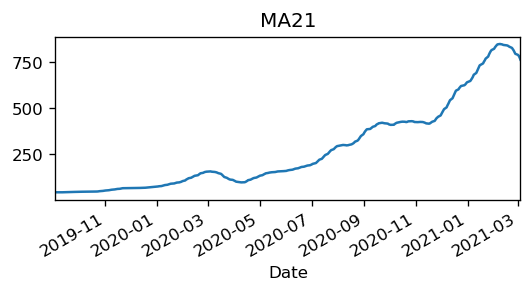

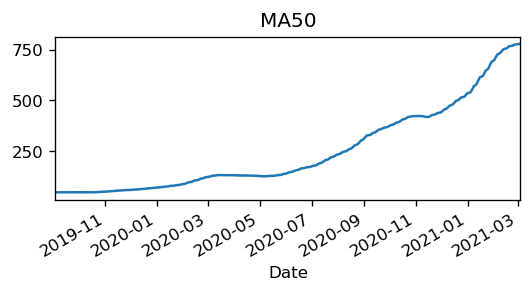

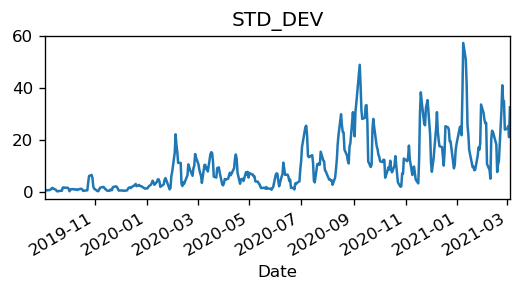

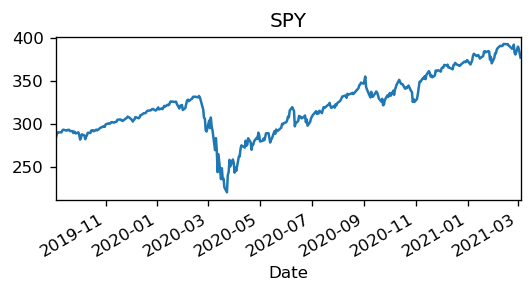

In [17]:
# Visualize all variables over time
plt.rcParams.update({'figure.figsize':(5,2), 'figure.dpi':120})
for c in list(tsla_df.columns):
    tsla_df[c].plot()
    plt.title(c)
    plt.show()

#### Add Sentiment Scores

We are also going to add our scores from our r/wallstreetbets sentiment analysis.

In [55]:
# Read in sentiment scores
wsb_df = pd.read_csv('.//Sentiment Analysis//Sentiment Scores.csv')
wsb_df['Created_EST'] = wsb_df['Created_EST'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
wsb_df = wsb_df.sort_values(by='Created_EST')
wsb_df = wsb_df[wsb_df['Created_EST'] > datetime(2019, 9, 1)].reset_index(drop=True)
wsb_df = wsb_df.fillna(method="pad")

# Because the data collected early on is such low volume, we are going to interpolate values for outliers that deviate 
# too far from the mean
wsb_df['interp'] = wsb_df['avg'].rolling(min_periods=1, center=True, window=12).mean()
wsb_df['avg'] = wsb_df.apply(lambda row: row['interp'] if (((row['Created_EST'] < datetime(2020,1,1)) & 
                                                           ((row['avg'] < 0.5) | (row['avg'] > 0.99))) |
                                                          (row['count'] < 10)) 
                             else row['avg'], axis=1)

We need to further aggregate our sentiment scores collected daily including weekends and holidays to join on our dataset that only reflects days the market is open for trading.

In [57]:
# Reaggregate sentiment scores based on market open days
wsb_df['join'] = 1
tsla_df['join'] = 1
tsla_df = tsla_df.reset_index()
wsb_df = tsla_df[['Date','TSLA','join']].merge(wsb_df, how='inner', on='join')

wsb_df = wsb_df[wsb_df['Created_EST'] <= wsb_df['Date']]
wsb_df = wsb_df.sort_values(by=['Date','Created_EST']).reset_index(drop=True)
wsb_df = wsb_df.drop_duplicates(subset='Created_EST')

adj_wsb_df = wsb_df.groupby('Date').apply(lambda x: pd.Series({
                                        'Weighted Sentiment Score': x['weighted_avg'].mean(),
                                        'Sentiment Score': x['avg'].mean(),
                                        'WB Score': x['wb'].mean(),
                                        'VADER Score': x['vader'].mean(),
                                        'Comment Volume': x['count'].sum()
                                        })).reset_index()

adj_wsb_df = adj_wsb_df.fillna(method="bfill")

In [58]:
# Join sentiment scores on TSLA
tsla_df = tsla_df.merge(adj_wsb_df, how='left', on='Date')

# Imputing missing values in sentiment
tsla_df = tsla_df.fillna(method="pad")

# Drop join column
tsla_df = tsla_df.drop('join', axis=1)

# backfill missing wsb data
tsla_df[['Sentiment Score','Weighted Sentiment Score','WB Score','VADER Score','Comment Volume']] = \
    tsla_df[['Sentiment Score','Weighted Sentiment Score','WB Score','VADER Score','Comment Volume']].fillna(method="bfill")

After comparison of the different scores, we have chosen to only include the original sentiment score in our model, omitting the weighted score, word bank score, and VADER score.

In [59]:
# drop unused sentiment scores
drop_cols = ['Weighted Sentiment Score','WB Score','VADER Score']
for col in drop_cols:
    tsla_df = tsla_df.drop(col, axis=1)

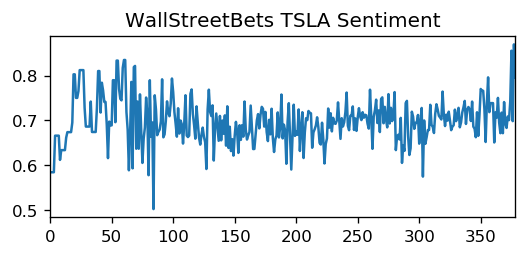

In [23]:
tsla_df['Sentiment Score'].plot()
plt.title('WallStreetBets TSLA Sentiment')
plt.show()

Either our sentiment analysis could be improved, or this shows us that the community's devotion to Tesla is so strong that sentiment remains extremely bullish regardless of changes in the stock price. In the future it may be worth pulling data from other sources, such as Twitter to gather sentiment from a less biased group.

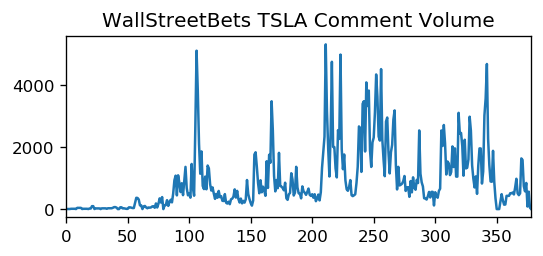

In [24]:
tsla_df['Comment Volume'].plot()
plt.title('WallStreetBets TSLA Comment Volume')
plt.show()

Volume on the otherhand appears to have some more variability. Perhaps this is correlated with the price and reflective of the group's excitement when TSLA is trading more actively. Let's plot against price to see if there is any merit to our hypothesis.

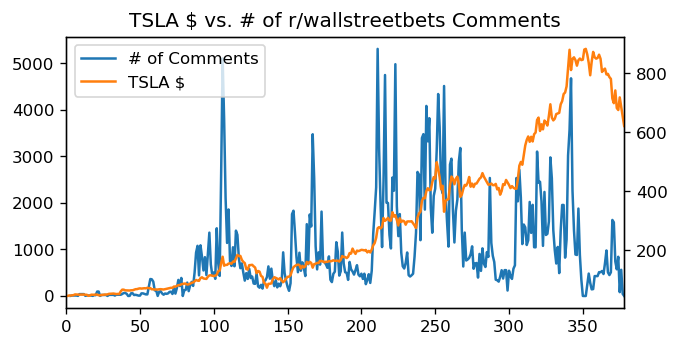

In [15]:
plt.rcParams.update({'figure.figsize':(6,3), 'figure.dpi':120})
tsla_df['Comment Volume'].plot(label="# of Comments", legend=True, title="TSLA $ vs. # of r/wallstreetbets Comments")
tsla_df['TSLA'].plot(secondary_y=True, label="TSLA $", legend=True, mark_right=False)

The plot shows large spikes in comment volume when TSLA is making an upward move. Volume tends to taper off when TSLA is trading side-ways, so this information may be useful.

#### Transform data and force order dependance into model

Now that we have all our variables, we need to prepare the data to fit our model. Because machine learning models do not consider the sequence of data in time like ARIMA does, we need to introduce time into the model using several dummy variables and lagged variables. We should also make our data stationary using differencing and log-transformations. In doing so, we will be transforming our target variable to predict the relative change in price instead of the absolute change in price.

In [60]:
def transform_series(df, col, log=False):
    """Log-transform and difference time series"""
    # add constant to series with negative values before log-transformation
    if log == True:
        if min(df[col]) < 0:
            df[col] += min(df[col])*-1
        df[col] = np.log(df[col]).replace(-np.inf,0).diff()
    else:
        df[col] = df[col].diff()
    return df

#Log-transform and difference series
log_transform_cols = ['TSLA','EMA', 'MA10', 'MA21', 'MA50', 'STD_DEV', 'SPY']

# difference series
reg_transform_cols = ['MACD','MACD_SIGNAL','MACD_HIST','MOMENTUM','RSI','Volume','Comment Volume']

for col in log_transform_cols:
    tsla_df = transform_series(tsla_df, col, log=True)
    
for col in reg_transform_cols:
    tsla_df = transform_series(tsla_df, col)

In [61]:
# scale volume
scaler = preprocessing.MinMaxScaler()
tsla_df[['Volume','Comment Volume']] = scaler.fit_transform(tsla_df[['Volume','Comment Volume']])

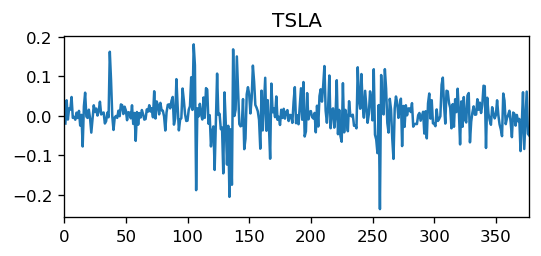

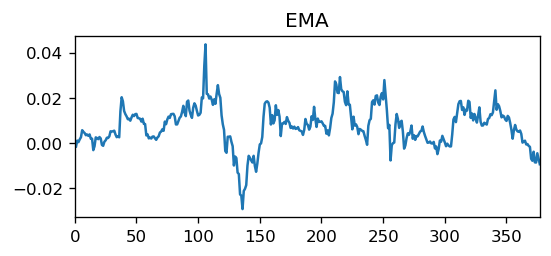

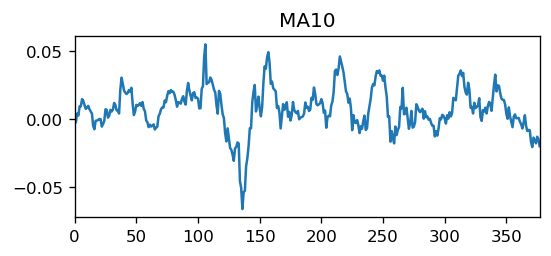

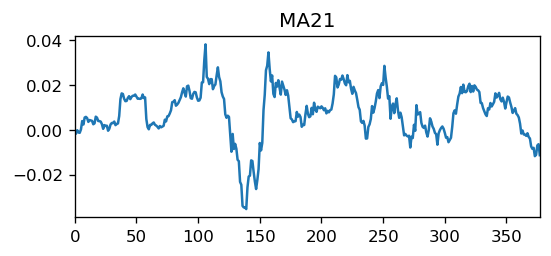

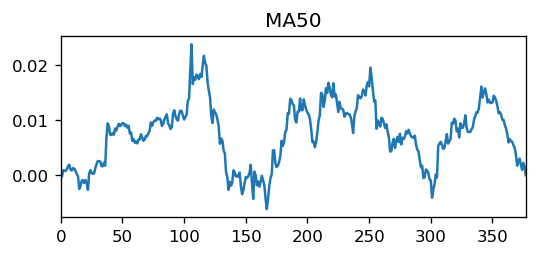

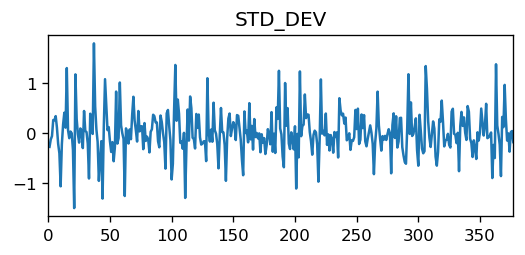

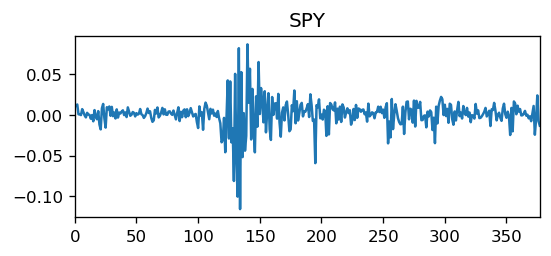

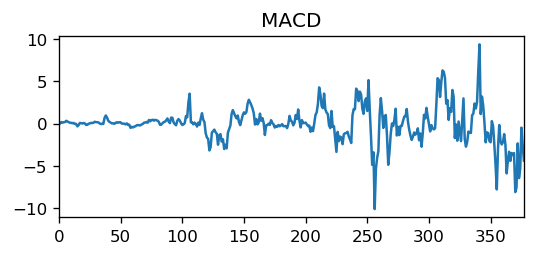

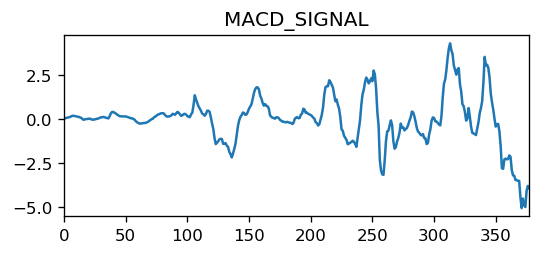

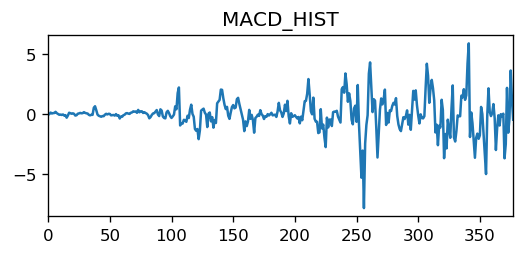

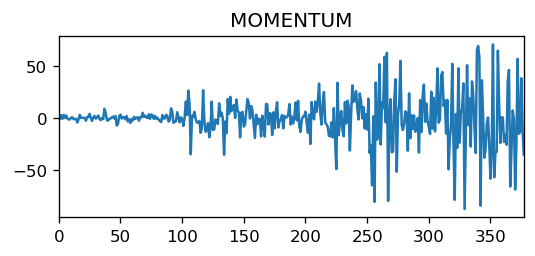

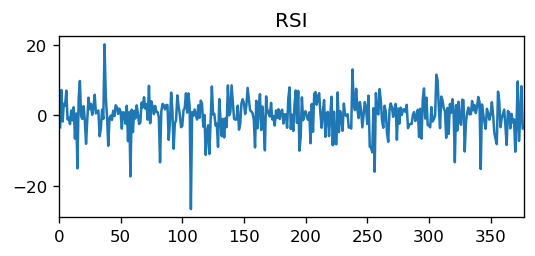

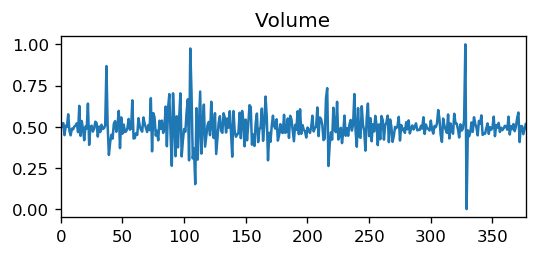

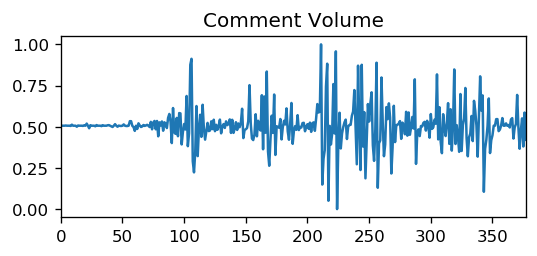

In [45]:
# Visualize all variables over time
plt.rcParams.update({'figure.figsize':(5,2), 'figure.dpi':120})
for c in list(log_transform_cols+reg_transform_cols):
    tsla_df[c][:-1].plot()
    plt.title(c)
    plt.show()

Now that we have made our features more stationary, we can add our time dummy variables.

In [62]:
# Add dummy variables
tsla_df['Day'] = tsla_df.index
tsla_df['Monthday'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%d')))
tsla_df['Week'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%W')))
tsla_df['Weekday'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%w')))
tsla_df['Month'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%m')))
tsla_df['Year'] = tsla_df['Date'].apply(lambda x: int(x.strftime('%y')))

# Drop Date variable
tsla_df = tsla_df.drop('Date', axis=1)

#### Correlation Matrix

Let's take a look at the correlation plot of our variables to get a sense of whether or not there is multi-collinearity present in our independent variables.

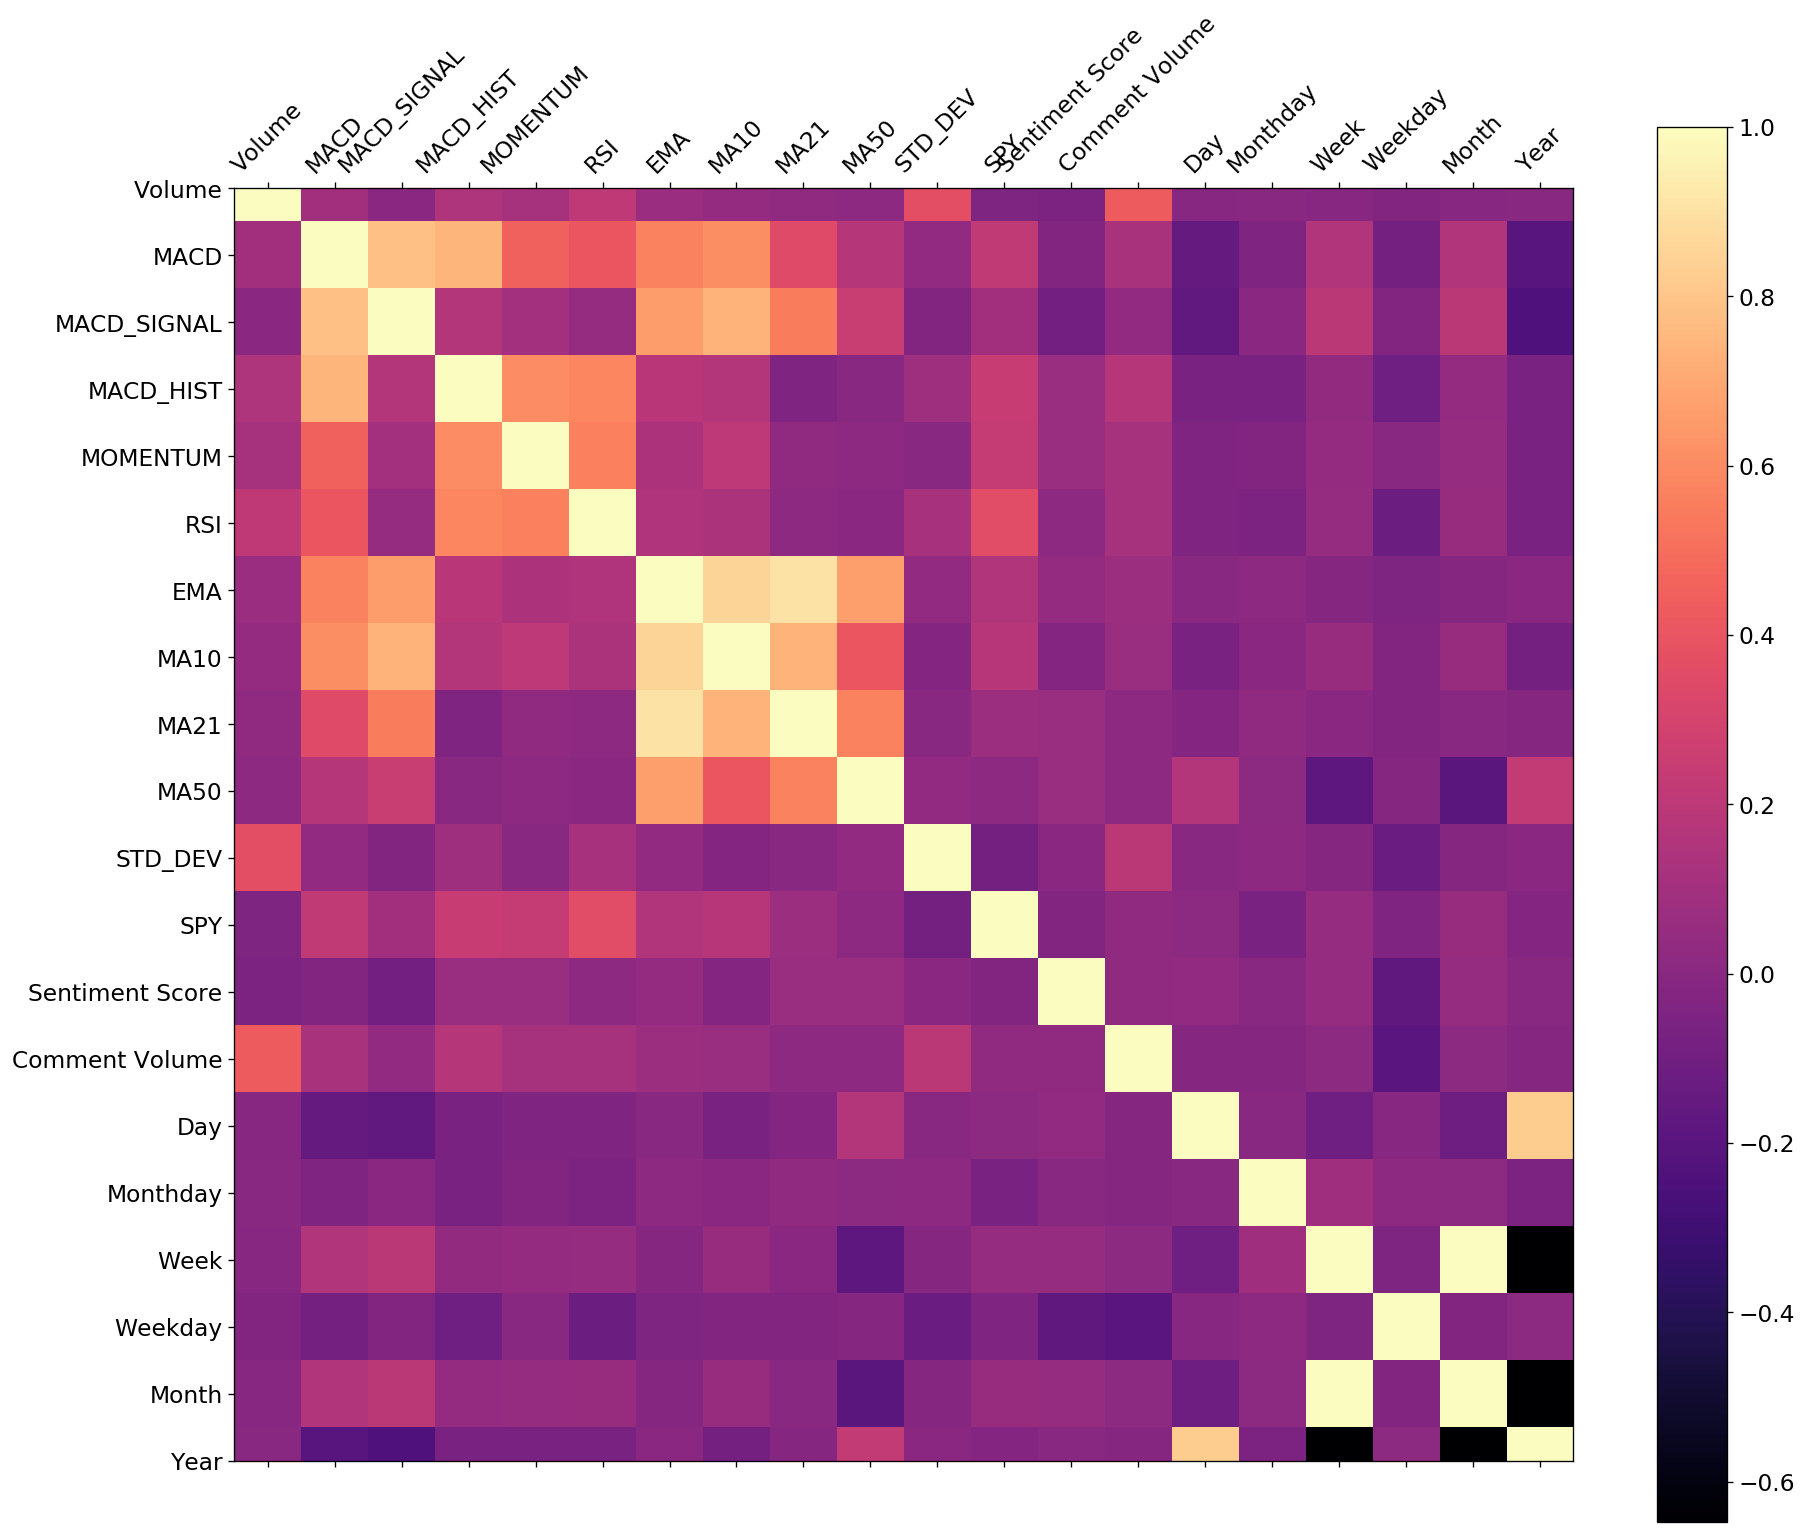

In [63]:
df = tsla_df.iloc[1:,1:]

f = plt.figure(figsize=(18, 15))
plt.matshow(df.corr(), fignum=f.number, cmap='magma') #inferno
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

The moving average indicators are highly correlated with one another. They also have a strong relationship with the MACD indicators. We can consider removing some of these from our model.

We still have one more step remaining, which is to add lagged variables to our features to allow our model to pick up on the sequence of our time series.

In [64]:
# Add lagged variables
for col in list(tsla_df.columns):
    tsla_df[col+'(t-1)'] = tsla_df[col].shift(1)
    
# Add target variable
tsla_df['TSLA(t+1)'] = tsla_df['TSLA'].shift(-1)

# Drop first two rows
tsla_df = tsla_df.iloc[2:,:].reset_index(drop=True)

In [65]:
# Bring target variable to front
tsla_cols = list(tsla_df.columns)
target_col = tsla_cols.pop()
tsla_cols = [target_col]+tsla_cols
tsla_df = tsla_df[tsla_cols]

In [66]:
tsla_df.head()

,TSLA(t+1),TSLA,Volume,MACD,MACD_SIGNAL,MACD_HIST,MOMENTUM,RSI,EMA,MA10,...,STD_DEV(t-1),SPY(t-1),Sentiment Score(t-1),Comment Volume(t-1),Day(t-1),Monthday(t-1),Week(t-1),Weekday(t-1),Month(t-1),Year(t-1)
0,-0.009321,0.039538,0.522077,0.176652,0.059398,0.117253,2.785999,7.192328,0.001052,0.003984,...,-0.280315,0.011287,0.583838,0.506230,1.0,4.0,35.0,3.0,9.0,19.0
1,0.018901,-0.009321,0.448726,0.110307,0.069580,0.040727,-0.689999,-1.761905,0.000376,0.002405,...,-0.131486,0.012773,0.583838,0.506230,2.0,5.0,35.0,4.0,9.0,19.0
2,0.016049,0.018901,0.506604,0.160295,0.087723,0.072572,3.018002,3.297713,0.001588,0.009200,...,-0.062968,0.000772,0.583838,0.506230,3.0,6.0,35.0,5.0,9.0,19.0
3,0.047912,0.016049,0.498537,0.188220,0.107823,0.080398,0.029999,2.690668,0.002549,0.009183,...,0.259945,0.000503,0.665584,0.507393,4.0,9.0,36.0,1.0,9.0,19.0
4,-0.004990,0.047912,0.575493,0.332557,0.152770,0.179788,2.495995,7.018949,0.005649,0.014588,...,0.254411,-0.000235,0.665584,0.506230,5.0,10.0,36.0,2.0,9.0,19.0


In [ ]:
tsla_df.to_csv('TSLA_processed.csv', index=False)

Now that we are finished processing the data, we are ready to train our machine learning models. 